### Import modules and packages

In [118]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import numpy as np
import os
import glob
import pandas as pd 
import h5py
import pickle
import cv2 as cv

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.signal as signal
from scipy.interpolate import LinearNDInterpolator, griddata
from datetime import datetime,timedelta
import pytz

import icewave.tools.matlab2python as mat2py
import icewave.sebastien.set_graphs as set_graphs
import icewave.drone.drone_projection as dp
import icewave.tools.matlab_colormaps as matcmaps
import icewave.tools.rw_data as rw
import icewave.gps.gps_seb as gps_seb
import icewave.gps.gps as gps
import icewave.geometry.tables as tables

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import buoys data

In [106]:
date = '0226'
base = f'K:/Share_hublot/Data/'
path2buoys = f'{base}{date}/BoueeVague/'

filelist = glob.glob(f'{path2buoys}**/mat/*.mat',recursive = True)

In [109]:
data_buoy = {}

buoys_list = ['B1','B2','B4','B5']
for key_buoy in buoys_list:
    path = f'{path2buoys}{key_buoy}/mat/*.mat'
    filelist = glob.glob(path)

    data_buoy[key_buoy] = {}
    for i in range(len(filelist)):
        file2load = filelist[i]
        with h5py.File(file2load, 'r') as fmat:
            print('Top-level keys : ', list(fmat.keys()))
    
            # create a key
            key_acq = f'acq_{i}'
            data_buoy[key_buoy][key_acq] = mat2py.mat_to_dict(fmat['IMU'],fmat['IMU'])

Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']
Top-level keys :  ['#refs#', 'IMU']


In [77]:
UTC_buoy = {}
u_buoy = {}

# build a filter for buoys
fs = 50 # sampling frequency
fc = 0.05 # cutoff frequency
order_filter = 4
b,a = signal.butter(order_filter,fc,'high',fs = fs)

# define acceleration keys
key_accel = ['ACCEL_X','ACCEL_Y','ACCEL_Z']
key_ufield = ['ux','uy','uz']
for key_buoy in data_buoy.keys():
    UTC_buoy[key_buoy] = {}
    u_buoy[key_buoy] = {}
    for key_acq in data_buoy[key_buoy].keys():
    
        UTC_buoy[key_buoy][key_acq] = []
        # Build UTC time for buoys
        Y = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['YEAR'][0])
        M = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['MONTH'][0])
        D = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['DAY'][0])
        H = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['HOUR'][0])
        MIN = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['MIN'][0])
        SEC = int(data_buoy[key_buoy][key_acq]['UTC_TIME']['SEC'][0])
    
        # initial UTC time for buoys
        UTC0 = datetime(Y,M,D,H,MIN,SEC)
        t0_epoch = UTC0.timestamp()
        t_epoch = t0_epoch + data_buoy[key_buoy][key_acq]['IMU_DATA']['t']
    
        for t in t_epoch:
            if not np.isnan(t):
                UTC_buoy[key_buoy][key_acq].append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))
    
        mask = ~np.isnan(t_epoch)
    
        # u_buoy[key] = {}
        current_u = np.array([data_buoy[key_buoy][key_acq]['IMU_DATA'][key_a][mask] for key_a in key_accel])
        # Apply filter to signal 
        current_u = signal.filtfilt(b,a,current_u,axis = -1)
        # Compute vertical velocity
        u_buoy[key_buoy][key_acq] = np.cumsum(current_u - np.mean(current_u,axis = -1,keepdims = True),axis = -1)/fs

In [110]:
u_buoy['B2'].keys()

dict_keys(['acq_0', 'acq_1', 'acq_2', 'acq_3'])

B1acq_0
B2acq_0
B4acq_0
B5acq_0
B1acq_1
B2acq_1
B4acq_1
B5acq_1
B1acq_2
B2acq_2
B4acq_2
B5acq_2
B1acq_3
B2acq_3
B4acq_3
B5acq_3


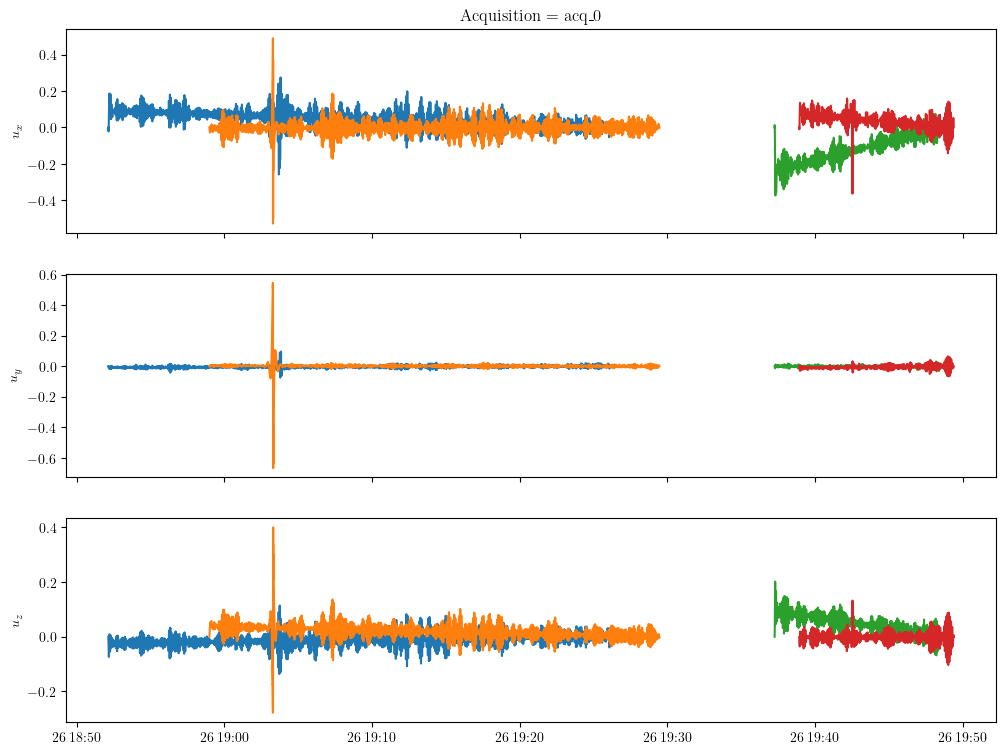

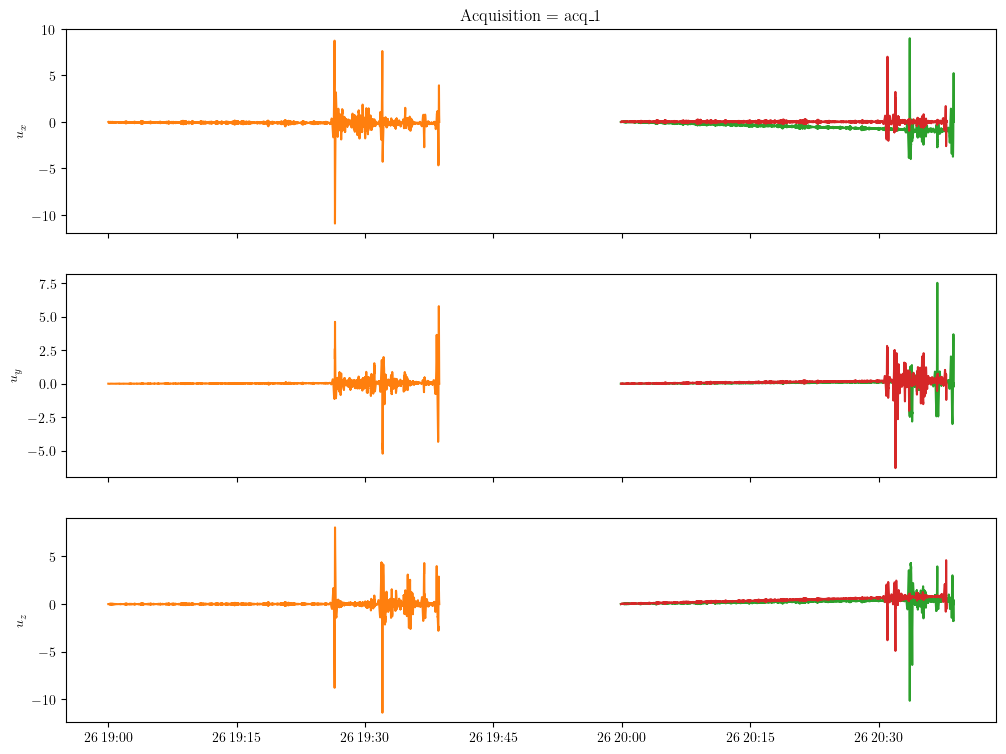

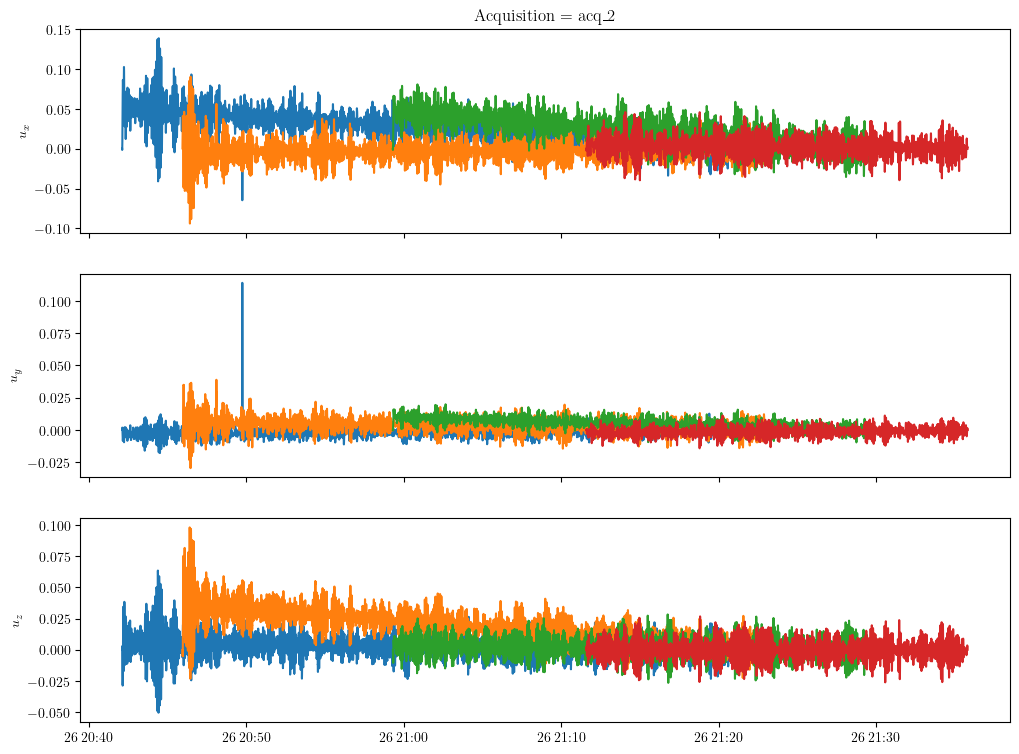

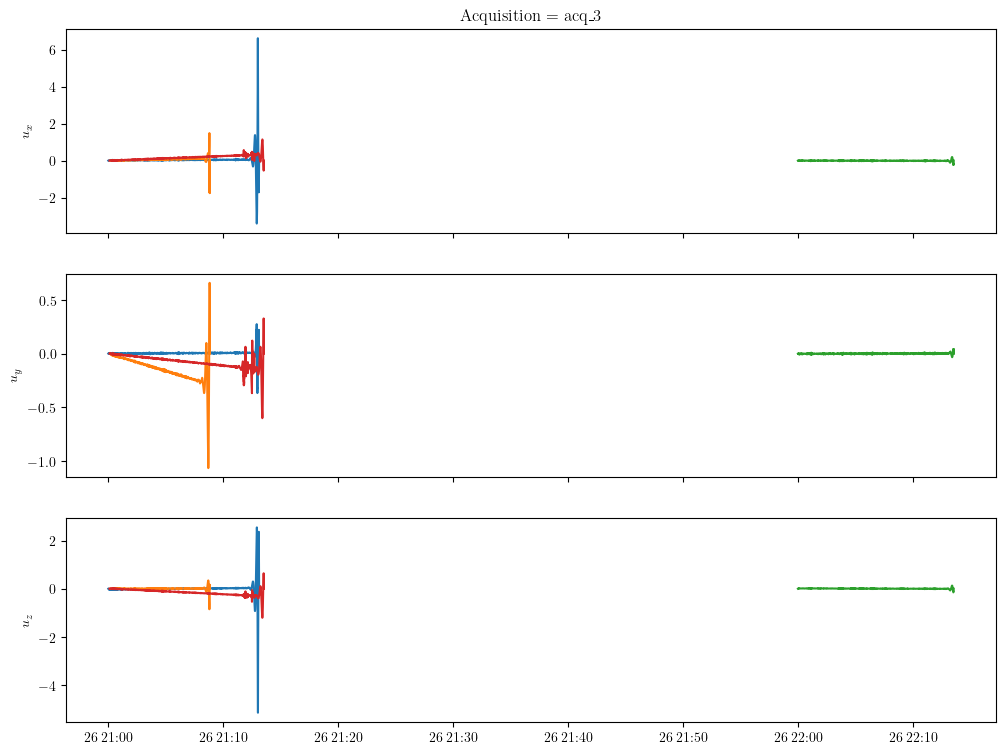

In [85]:
idx_u = 2 # 0 = u_x, 1 = u_y, 2 = u_z

key_buoys = list(u_buoy.keys())
color_table = ['tab:blue','tab:orange','tab:green','tab:red']
acquisition = np.arange(0,4)

# outlier = 'B1_1900'
outlier = 'B1acq_1'

for key_acq in u_buoy['B1'].keys():
    fig, axs = plt.subplots(figsize = (12,9),ncols = 1, nrows = 3,sharex = True)

    for i,key_buoy in enumerate(u_buoy.keys()):
        current_color = color_table[i]

        test = key_buoy + key_acq
        print(test)
        if test != outlier:
            for idx_u in range(3):
                axs[idx_u].plot(UTC_buoy[key_buoy][key_acq],u_buoy[key_buoy][key_acq][idx_u,:],'-',color = current_color)

    axs[0].set_ylabel(r'$u_x$')
    axs[1].set_ylabel(r'$u_y$')
    axs[2].set_ylabel(r'$u_z$')
    axs[0].set_title(f'Acquisition = {key_acq}')
    
    # for i in range(0 + acqu,len(key_buoys),4):
    #     print(i)
    #     key = key_buoys[i]
    #     current_color = color_table[i//4]
    #     print(i//4)
    #     if key != outlier :
    #         for idx_u in range(3):
    #             axs[idx_u].plot(UTC_buoy[key],u_buoy[key][idx_u,:],'-',color = current_color)
    
    # axs[0].set_ylabel(r'$u_x$')
    # axs[1].set_ylabel(r'$u_y$')
    # axs[2].set_ylabel(r'$u_z$')
    # axs[0].set_title(f'Acquisition = {acqu}')


### Load Drone data

In [111]:
drone_ID = 'mesange'
exp_ID = '12-FRAC_001'
path2drone = f'{base}{date}/Drones/{drone_ID}/matData/{exp_ID}/'
file2load = glob.glob(f'{path2drone}*scaled.h5')[0]

S = rw.load_dict_from_h5(file2load)

In [150]:
print(S.keys())
print(S['PIV_param'])

dict_keys(['DRONE', 'GPS', 'ID', 'PIV_param', 'PIXEL', 'SCALE', 'UTC_t', 'Vz', 'X', 'Y', 'err_uz', 'name', 't', 't0_UTC', 'units', 'ux', 'uz', 'x', 'xref', 'y', 'yref'])
{'Dt': np.float64(7.0), 'N': np.float64(0.0), 'ROI': {'height': np.float64(2159.0), 'width': np.float64(3839.0), 'x': np.float64(1.0), 'y': np.float64(1.0)}, 'a': np.float64(0.0), 'b': np.float64(1.0), 'i0': np.float64(0.0), 'w': np.float64(32.0)}


### Create UTC time array for drone

In [112]:
datetime_format = '%Y-%m-%d %H:%M:%S.%f'
UTC_0 = datetime.strptime(S['t0_UTC'] + '000',datetime_format)
UTC_0 = UTC_0.replace(tzinfo = pytz.utc)

t0_epoch_drone = UTC_0.timestamp()
t_epoch_drone = t0_epoch_drone + S['t']
UTC_drone = []
for t in t_epoch_drone:
    if not np.isnan(t):
        UTC_drone.append(datetime.fromtimestamp(t).replace(tzinfo = pytz.utc))


### Spatio temporal plot

Text(0, 0.5, '$x \\; \\mathrm{(m)}$')

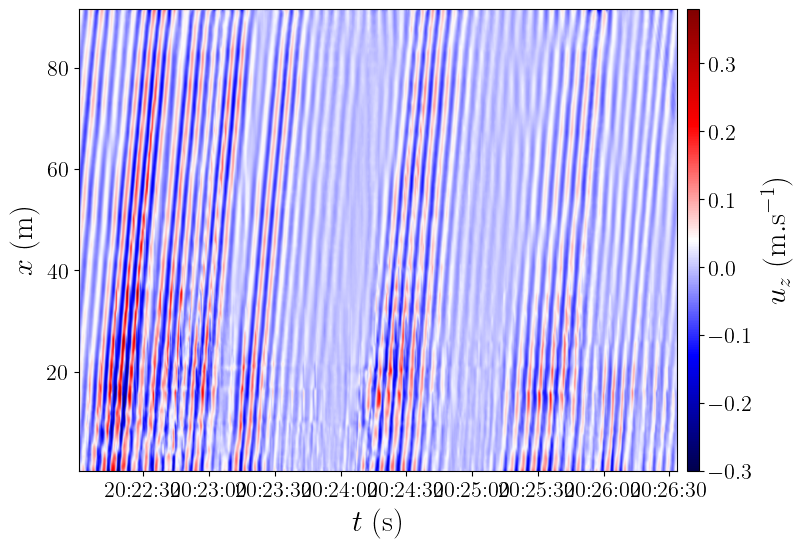

In [113]:
extents_spatio = [UTC_drone[0],UTC_drone[-1],S['x'][0],S['x'][-1]]
fig,ax = plt.subplots()
imsh = ax.imshow(S['uz'],origin = 'lower',aspect = 'auto',cmap = 'seismic',
          interpolation = 'gaussian',extent = extents_spatio)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(imsh,cax = cax)
cbar.set_label(r'$u_z \; \mathrm{(m.s^{-1})}$')

ax.set_xlabel(r'$t \; \mathrm{(s)}$',labelpad = 5)
ax.set_ylabel(r'$x \; \mathrm{(m)}$',labelpad = 5)

### Compute buoys GPS positions

In [114]:
buoys_GPS = {}
key_nav = 'GPS1_POS'
for key_buoy in data_buoy.keys():
    buoys_GPS[key_buoy] = {}
    for key_acq in data_buoy[key_buoy].keys():
    
        lat = data_buoy[key_buoy][key_acq][key_nav]['LAT']
        long = data_buoy[key_buoy][key_acq][key_nav]['LONG']
        
        buoys_GPS[key_buoy][key_acq] = {}
        buoys_GPS[key_buoy][key_acq]['latitude'] = np.mean(lat)
        buoys_GPS[key_buoy][key_acq]['longitude'] = np.mean(long)

In [58]:
key_buoy = 'B1_1800'
data_buoy[key_buoy].keys()

dict_keys(['EKF_EULER', 'EKF_NAV', 'EKF_QUAT', 'GPS1_HDT', 'GPS1_POS', 'GPS1_VEL', 'IMU_DATA', 'MAG', 'STATUS', 'UTC_TIME', 'file_name', 'mdir', 'mname'])

In [60]:

data_buoy[key_buoy]['GPS1_POS'].keys()

dict_keys(['ALT', 'BASE_STATION_ID', 'CRC', 'CRC_CALC', 'DIFF_AGE', 'GPS_POS_STATUS', 'GPS_TOW', 'LAT', 'LONG', 'NUM_SV_USED', 'POS_ACC_ALT', 'POS_ACC_LAT', 'POS_ACC_LONG', 'TIME_STAMP', 'TS_fix', 'UNDULATION', 't', 'time'])

### Plot buoys GPS position and drone GPS positions

In [132]:
# load Stephane GPS data
path2gps = f'{base}{date}/GPS/'
gpx_filelist = glob.glob(path2gps + '*.gpx')

gpx_file = gpx_filelist[0]
# get gpx
gpx = gps.get_wpts(gpx_file)

# use Map_table to create a dictionnary
data_gps = tables.dict_from_gpx(gpx,path2gps)

waypoint Sag240288, Mon Feb 26 17:13:21 2024 -> (48.348653,-68.799496)
waypoint Sag240289, Mon Feb 26 17:33:45 2024 -> (48.347318,-68.80523)
waypoint Sag240290, Mon Feb 26 17:47:27 2024 -> (48.347681,-68.809319)
waypoint Sag240291, Mon Feb 26 17:48:29 2024 -> (48.34765,-68.809562)
waypoint Sag240292, Mon Feb 26 17:50:02 2024 -> (48.347664,-68.809648)
waypoint Sag240293, Mon Feb 26 17:51:56 2024 -> (48.347902,-68.810624)
waypoint Sag240294, Mon Feb 26 17:53:06 2024 -> (48.347938,-68.81077)
waypoint Sag240295, Mon Feb 26 17:53:58 2024 -> (48.348046,-68.811198)
waypoint Sag240296, Mon Feb 26 17:56:57 2024 -> (48.348378,-68.813141)
waypoint Sag240297, Mon Feb 26 17:58:04 2024 -> (48.348591,-68.81318)
waypoint Sag240298, Mon Feb 26 17:59:01 2024 -> (48.348618,-68.813167)
waypoint Sag240299, Mon Feb 26 18:01:59 2024 -> (48.348378,-68.814837)
waypoint Sag240300, Mon Feb 26 18:04:56 2024 -> (48.34837,-68.814728)
waypoint Sag240301, Mon Feb 26 18:07:15 2024 -> (48.347961,-68.814634)
waypoint Sa

In [142]:
data_gps.keys()

dict_keys(['depart', 'H_01', 'H_02', 'H_03', 'H_04', 'H_05', 'H_06', 'H_07', 'H_08', 'H_09', 'H_10', 'G_0101', 'G_0216', 'G_0116', 'plot_04', 'plot_05', 'S_0101', 'H_11', 'S_0102', 'S_0103', 'B_0101', 'T_0100', 'T_0101', 'T_0104', 'H_12', 'T_9900', 'B_0104', 'G_0316', 'T_0105', 'T_0108', 'H_13', 'T_0107', 'G_0301', 'H_14', 'H_15', 'T_0109', 'T_0110', 'T_0111', 'T_0112', 'T_0119', 'T_0201', 'plot_11', 'plot_12', 'plot_13', 'plot_14', 'T_0200', 'T_0204', 'B_0203', 'T_0205', 'B_0204', 'T_0207', 'B_0205', 'B_0207', 'T_0208', 'T_0209', 'T_0210', 'T_0211', 'T_0212'])

In [144]:
# keep only gps position of buoys
data_gps_buoy = {}
for key in data_gps.keys():
    instrument = key[0]
    if instrument == 'B' or instrument == 'T':
        data_gps_buoy[key] = data_gps[key]

d
H
H
H
H
H
H
H
H
H
H
G
G
G
p
p
S
H
S
S
B
T
T
T
H
T
B
G
T
T
H
T
G
H
H
T
T
T
T
T
T
p
p
p
p
T
T
B
T
B
T
B
B
T
T
T
T
T


In [145]:
data_gps_buoy

{'B_0101': {'longitude': -68.814998,
  'latitude': 48.348339,
  'elevation': -2.347648,
  'time': datetime.datetime(2024, 2, 26, 18, 24, 29, tzinfo=SimpleTZ('Z'))},
 'T_0100': {'longitude': -68.814769,
  'latitude': 48.348358,
  'elevation': -0.927035,
  'time': datetime.datetime(2024, 2, 26, 18, 26, 37, tzinfo=SimpleTZ('Z'))},
 'T_0101': {'longitude': -68.814398,
  'latitude': 48.34839,
  'elevation': -0.674547,
  'time': datetime.datetime(2024, 2, 26, 18, 29, 9, tzinfo=SimpleTZ('Z'))},
 'T_0104': {'longitude': -68.814687,
  'latitude': 48.347959,
  'elevation': -0.433199,
  'time': datetime.datetime(2024, 2, 26, 18, 33, 23, tzinfo=SimpleTZ('Z'))},
 'T_9900': {'longitude': -68.814363,
  'latitude': 48.348183,
  'elevation': -1.61996,
  'time': datetime.datetime(2024, 2, 26, 18, 44, 12, tzinfo=SimpleTZ('Z'))},
 'B_0104': {'longitude': -68.813802,
  'latitude': 48.348438,
  'elevation': -0.005396,
  'time': datetime.datetime(2024, 2, 26, 18, 47, 44, tzinfo=SimpleTZ('Z')),
  'value': 'A_

In [43]:
# Load image 
path2img = f'{base}{date}/Drones/{drone_ID}/{exp_ID}/images/*0684*.tiff'
filelist_img = glob.glob(path2img)
file2load = filelist_img[0]

img = cv.imread(file2load)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

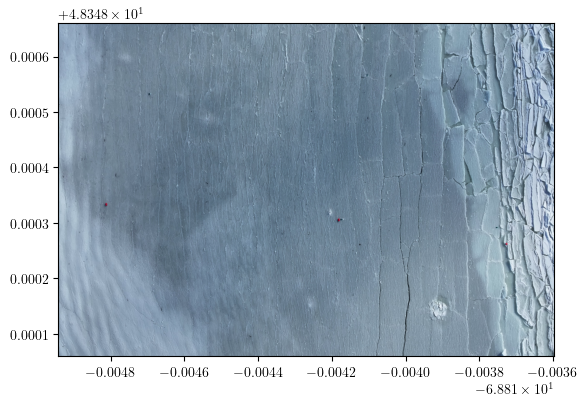

In [49]:
# plot image 
GPS_D = (S['GPS']['latitude'],S['GPS']['longitude'],S['GPS']['azimuth'])
Lat,Long = dp.georeference_from_param(img,S['DRONE']['h_drone'],S['DRONE']['alpha_0'],S['DRONE']['focale'],GPS_D)

extents = [Long.min(),Long.max(),Lat.min(),Lat.max()]
fig, ax = plt.subplots()
imsh = ax.imshow(img,extent = extents)
ax.set_aspect(1/np.cos(S['GPS']['latitude']*np.pi/180)) # scaling y/x

Text(0, 0.5, 'Latitude (°)')

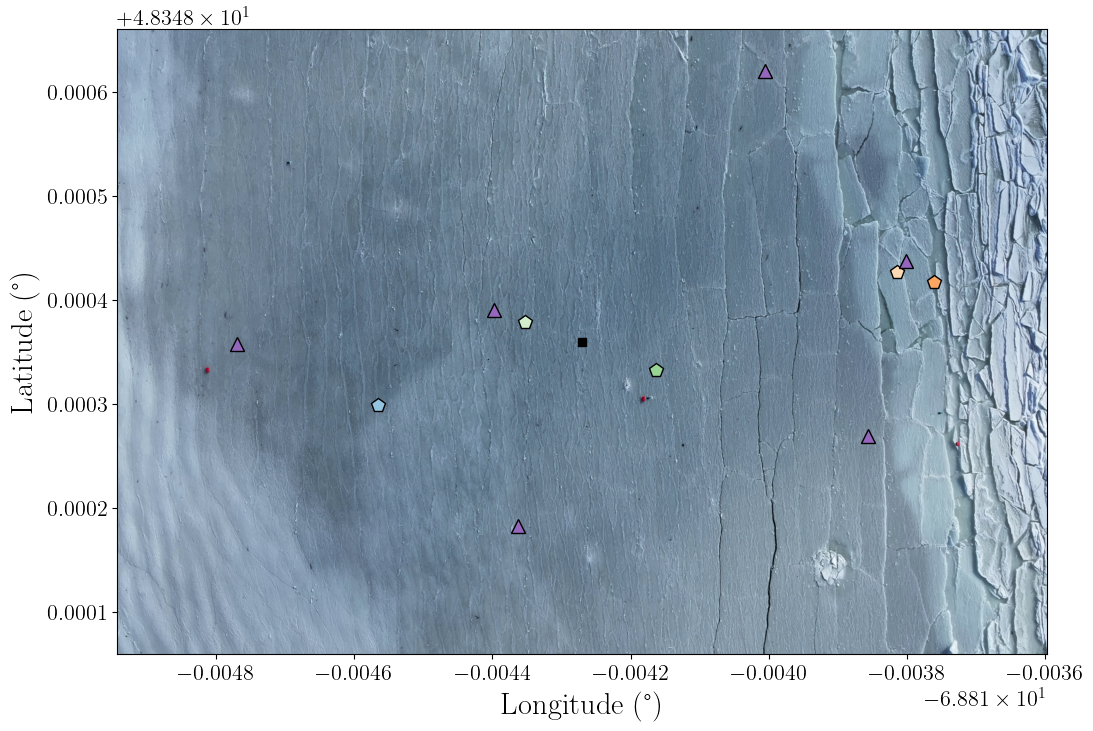

In [149]:
# create a dictionnary for buoy colors
norm = mcolors.Normalize(vmin = 0, vmax = 3)

cmap_dict = {'B1':'Blues','B2':'Greens','B4':'Oranges','B5':'Reds'}

GPS_D = (S['GPS']['latitude'],S['GPS']['longitude'],S['GPS']['azimuth'])
Lat,Long = dp.georeference_from_param(img,S['DRONE']['h_drone'],S['DRONE']['alpha_0'],S['DRONE']['focale'],GPS_D)

set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots(figsize = (12,9))

extents = [Long.min(),Long.max(),Lat.min(),Lat.max()]
imsh = ax.imshow(img,extent = extents)

ax.plot(S['GPS']['longitude'],S['GPS']['latitude'],'ks')

for key_buoy in buoys_GPS.keys():
    full_cmap = mpl.colormaps[cmap_dict[key_buoy]].resampled(256)
    cmap = mcolors.ListedColormap(full_cmap(np.linspace(0.2,0.8,256)))
    for i,key_acq in enumerate(buoys_GPS[key_buoy].keys()):
        current_color = cmap(norm(i))
        ax.plot(buoys_GPS[key_buoy][key_acq]['longitude'],buoys_GPS[key_buoy][key_acq]['latitude'],'p',
                color = current_color,mec = 'k',ms = 10)

for key in data_gps_buoy.keys():
    ax.plot(data_gps_buoy[key]['longitude'],data_gps_buoy[key]['latitude'],'^',color = 'tab:purple',mec = 'k',ms = 10)
    # test = np.logical_and(data_gps_buoy[key]['longitude'] > extents[0], data_gps_buoy[key]['longitude'] < extents[1],
    #                       data_gps_buoy[key]['latitude'] > extents[2], data_gps_buoy[key]['latitude'] > extents[3])
    # ax.text(data_gps_buoy[key]['longitude'],data_gps_buoy[key]['latitude'],key)

ax.set_aspect(1/np.cos(S['GPS']['latitude']*np.pi/180)) # scaling y/x
ax.set_xlim([Long.min(),Long.max()])
ax.set_ylim([Lat.min(),Lat.max()])

ax.set_xlabel(r'Longitude (°)')
ax.set_ylabel(r'Latitude (°)')